In [1]:
import os, math
import numpy as np
import pandas as pd
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("../input/ion-clean/train_full_clean.csv")
test = pd.read_csv("../input/ion-clean/test_full_clean.csv")

train["group"] = np.arange(train.shape[0]) // 500_000

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# signal processing features
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

def calc_low_pass(s, n_filts=5):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=5):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_ewm(s, windows=[10, 100]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

def calc_signal_features(s):
    '''
    All calculations together
    '''
#     gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, low_pass, high_pass, ewm], axis=1)

def signal_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s / 15.0
    
    ls = []
    for i in range(s.shape[0]//signal_size):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = calc_signal_features(sig)
        ls.append(sig_featured)
    
    ls = pd.concat(ls, axis=0)
    return ls[ls.columns[1:]]

In [5]:
# rolling and aggreagate batch features
def rolling_features(df):
    for window in [10, 100]:
        # rolling
        df['mean_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).mean())
        df['std_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).std())
        df['var_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).var())
        df['q25_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.25))
        df['q50_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.50))
        df['q75_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).quantile(0.75))
        df['min_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).min())
        df['max_t' + str(window)] = df.groupby(['group'])['signal'].transform(lambda x: x.rolling(window).max())
        min_max = (df['signal'] - df['min_t' + str(window)]) / (df['max_t' + str(window)] - df['min_t' + str(window)])
        df['norm_t' + str(window)] = min_max * (np.floor(df['max_t' + str(window)]) - np.ceil(df['min_t' + str(window)]))
    return df.fillna(0)

# static and aggreagate batch features
def static_features(df):
    df['mean_b'] = df.groupby(['group'])['signal'].mean()
    df['std_b'] = df.groupby(['group'])['signal'].std()
    df['var_b'] = df.groupby(['group'])['signal'].var()
    df['q25_b'] = df.groupby(['group'])['signal'].quantile(0.25)
    df['q50_b'] = df.groupby(['group'])['signal'].quantile(0.50)
    df['q75_b'] = df.groupby(['group'])['signal'].quantile(0.75)
    df['min_b'] = df.groupby(['group'])['signal'].min()
    df['max_b'] = df.groupby(['group'])['signal'].max()
    min_max = (df['signal'] - df['min_b']) / (df['max_b'] - df['min_b'])
    df['norm_b'] = min_max * (np.floor(df['max_b']) - np.ceil(df['min_b']))
    return df.fillna(0)

def shifted_features(df, num_shift=5):
    steps = np.arange(1, num_shift+1, dtype=np.int32)
    steps = np.append(steps, -steps)
    for step in steps:
        df['signal_shift_' + str(step)] = df['signal'].shift(step, fill_value=0).astype( np.float32 )
    return df

def add_features(df):
    df = shifted_features(df)
#     df = static_features(df)
    df = rolling_features(df)
    df['signal_2'] = (df['signal'] ** 2)
    df = reduce_mem_usage(df).reset_index(drop=True)
    sg_df = signal_features(df['signal'])
    sg_df = reduce_mem_usage(sg_df).reset_index(drop=True)
    return pd.concat([df, sg_df], axis=1)

In [6]:
%%time

train_features = add_features(train)
train_features = train_features.drop(['time', 'group', 'open_channels'], axis=1)
print(train_features.shape)
train_features.head()

Mem. usage decreased to 338.55 Mb (68.3% reduction)
Mem. usage decreased to 267.03 Mb (72.0% reduction)
(5000000, 54)
CPU times: user 34.6 s, sys: 8.22 s, total: 42.9 s
Wall time: 42.5 s


,signal,signal_shift_1,signal_shift_2,signal_shift_3,signal_shift_4,signal_shift_5,signal_shift_-1,signal_shift_-2,signal_shift_-3,signal_shift_-4,...,highpass_lf_0.0891,highpass_ff_0.0891,highpass_lf_0.2661,highpass_ff_0.2661,highpass_lf_0.7943,highpass_ff_0.7943,ewm_mean_10,ewm_std_10,ewm_mean_100,ewm_std_100
0,-0.016342,0.000000,0.000000,0.000000,0.000000,0.0,-0.093018,0.265625,-0.321045,-0.330811,...,0.000000,0.000190,0.000000,-0.000003,0.000000,-0.000020,-0.001089,0.000000,-0.001089,0.000000
1,-0.093018,-0.016342,0.000000,0.000000,0.000000,0.0,0.265625,-0.321045,-0.330811,0.077576,...,-0.004482,-0.004574,-0.003542,-0.005482,-0.001283,-0.004025,-0.003902,0.003616,-0.003672,0.003616
2,0.265625,-0.093018,-0.016342,0.000000,0.000000,0.0,-0.321045,-0.330811,0.077576,0.031433,...,0.017593,0.019913,0.015198,0.019821,0.006638,0.006435,0.004787,0.013290,0.003601,0.012665
3,-0.321045,0.265625,-0.093018,-0.016342,0.000000,0.0,-0.330811,0.077576,0.031433,0.115906,...,-0.021042,-0.018311,-0.021240,-0.013947,-0.013123,-0.004135,-0.003841,0.017639,-0.002840,0.016296
4,-0.330811,-0.321045,0.265625,-0.093018,-0.016342,0.0,0.077576,0.031433,0.115906,0.055908,...,-0.016403,-0.018753,-0.008621,-0.013481,0.006378,-0.000932,-0.009071,0.017181,-0.006836,0.016525


In [7]:
%%time

corr_mat = train_features.corr()
corr_mat.shape

CPU times: user 35.3 s, sys: 1.47 s, total: 36.8 s
Wall time: 36.9 s


(54, 54)

In [8]:
def display_correlation_matrix(corr_mat, feature_cols):
    plt.figure(figsize=(16,14))
    ax = sns.heatmap(corr_mat, vmin=-1.5, vmax=1.5, center=0, cmap="RdBu")
    ax.set_facecolor("gold")
    ax.collections[0].colorbar.ax.set_ylim(-1.0, 1.0)
    # set/rotate ticks
    ax.set_xticks(range(len(feature_cols)))
    ax.set_xticklabels(feature_cols, fontdict={'fontsize': 8})
    ax.set_yticks(range(len(feature_cols)))
    ax.set_yticklabels(feature_cols, fontdict={'fontsize': 8})
    plt.show()

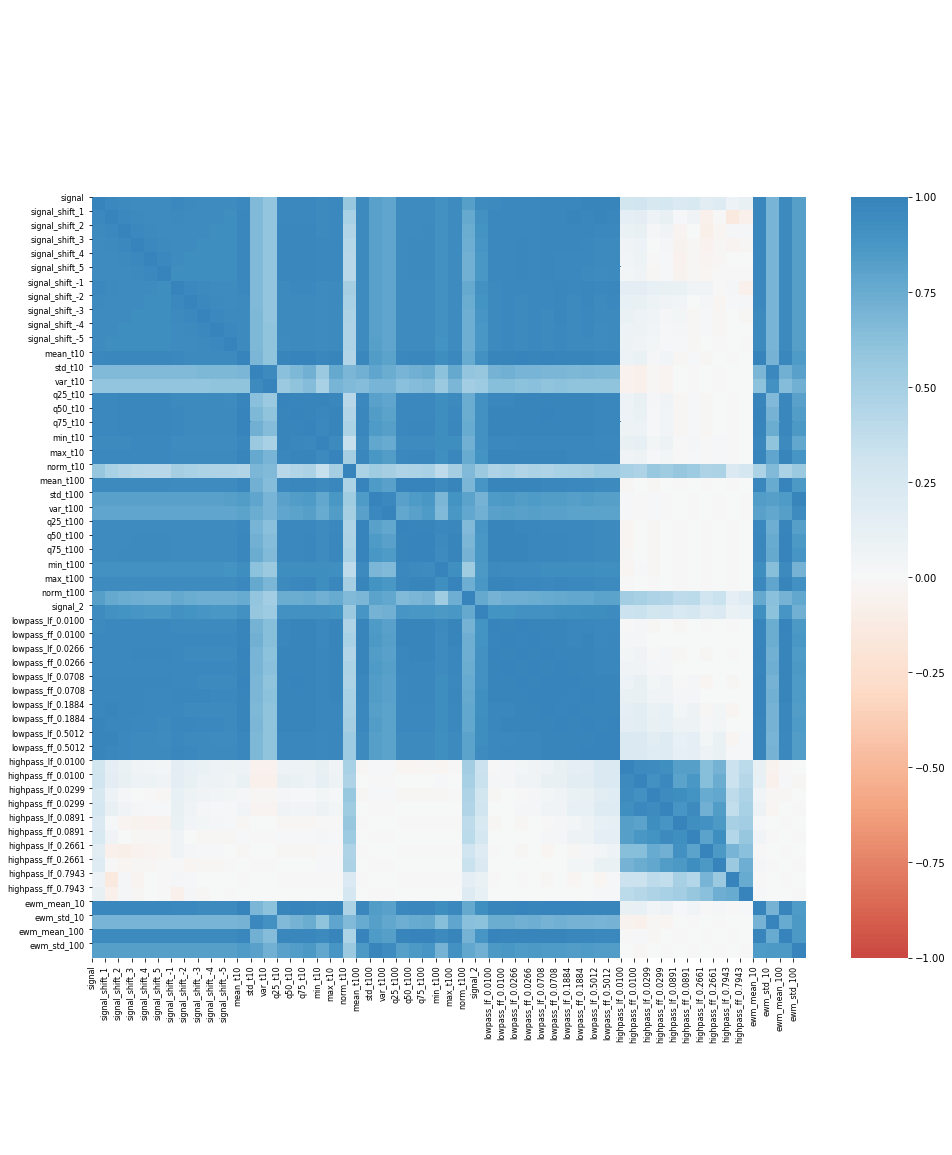

In [9]:
display_correlation_matrix(corr_mat, train_features.columns)